<a href="https://colab.research.google.com/github/codebluecruz/Hyper-Parameter-Optimization-of-Decision-Tree-/blob/master/FO_With_HO_RS_RF_Vtreat_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [3]:
sdss_df = pd.read_csv('Romcom.csv', skiprows=0)

In [4]:
sdss_df.head()

,UniqueId,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,Sentiment_Rating
0,1,75 or over,Incomplete or Infrequent Bowel Movements,11/23/2009,miralax 17 gram oral powder packet,17116,5,3,"I have success taking this drug, but have had ...",4,Female,"Nausea , abdominal cramping, or gas may occur.",13,4
1,2,55-64,Rheumatoid Arthritis,11-01-2010,meloxicam,911,4,4,unfortunately this drug causes me migrane like...,2,Female,"Stomach upset, nausea , dizziness , or dia...",3,1
2,3,65-74,Sensation of Spinning or Whirling,3/19/2008,meclizine hcl,4520,4,4,"diagnosed with vertigo, this medication taken ...",4,Male,"Drowsiness, dry mouth , and tiredness may occur.",10,4
3,4,25-34,Depression,03-02-2011,mirtazapine tablet,13706,3,1,Placed on this medicine after being taken off ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",20,1
4,5,19-24,Depression,04-01-2011,mirtazapine,13706,3,1,i have only been on this drug for one week. I ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",28,1


In [5]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   UniqueId          29998 non-null  int64 
 1   Age               29998 non-null  object
 2   Condition         29998 non-null  object
 3   Date              29998 non-null  object
 4   Drug              29998 non-null  object
 5   DrugId            29998 non-null  int64 
 6   EaseofUse         29998 non-null  int64 
 7   Effectiveness     29998 non-null  int64 
 8   Reviews           29998 non-null  object
 9   Satisfaction      29998 non-null  int64 
 10  Sex               29998 non-null  object
 11  Sides             29998 non-null  object
 12  UsefulCount       29998 non-null  int64 
 13  Sentiment_Rating  29998 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.2+ MB


In [6]:
sdss_df.describe()

,UniqueId,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
count,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000
mean,14999.500000,30174.666444,3.987366,3.665778,3.152577,6.708747,3.164944
std,8659.821024,49354.867556,1.364891,1.438950,1.618441,9.935583,1.721518
min,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7500.250000,6007.000000,3.000000,3.000000,1.000000,1.000000,1.000000
50%,14999.500000,6997.000000,5.000000,4.000000,3.000000,3.000000,3.000000
75%,22498.750000,19937.000000,5.000000,5.000000,5.000000,9.000000,5.000000
max,29998.000000,177317.000000,5.000000,5.000000,5.000000,178.000000,5.000000


In [7]:
sdss_df['Satisfaction'].value_counts()

5    9587
1    8246
4    4917
3    4226
2    3022
Name: Satisfaction, dtype: int64

In [8]:
sdss_df.columns.values

array(['UniqueId', 'Age', 'Condition', 'Date', 'Drug', 'DrugId',
       'EaseofUse', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'Sides', 'UsefulCount', 'Sentiment_Rating'], dtype=object)

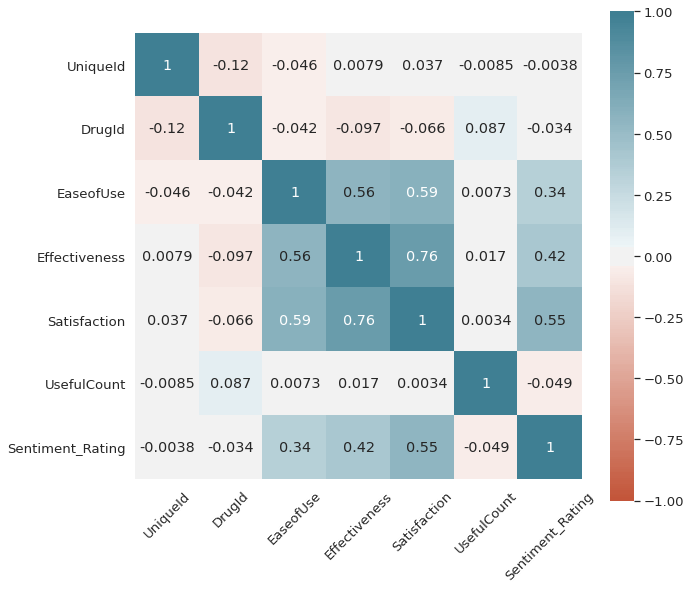

In [9]:
import seaborn as sns
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [10,9]
sns.set(font_scale = 1.2)
corr = sdss_df.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

In [10]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['Satisfaction'])
sdss_df_fe['Satisfaction'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
#sdss_df_fe.drop(['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating'], axis=1, inplace=True)
sdss_df_fe.drop(['PCA_1', 'PCA_2', 'PCA_3'], axis=1, inplace=True)
sdss_df_fe.head()

,UniqueId,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,Sentiment_Rating
0,1,75 or over,Incomplete or Infrequent Bowel Movements,11/23/2009,miralax 17 gram oral powder packet,17116,5,3,"I have success taking this drug, but have had ...",3,Female,"Nausea , abdominal cramping, or gas may occur.",13,4
1,2,55-64,Rheumatoid Arthritis,11-01-2010,meloxicam,911,4,4,unfortunately this drug causes me migrane like...,1,Female,"Stomach upset, nausea , dizziness , or dia...",3,1
2,3,65-74,Sensation of Spinning or Whirling,3/19/2008,meclizine hcl,4520,4,4,"diagnosed with vertigo, this medication taken ...",3,Male,"Drowsiness, dry mouth , and tiredness may occur.",10,4
3,4,25-34,Depression,03-02-2011,mirtazapine tablet,13706,3,1,Placed on this medicine after being taken off ...,0,Female,"Dizziness , drowsiness, lightheadedness , inc...",20,1
4,5,19-24,Depression,04-01-2011,mirtazapine,13706,3,1,i have only been on this drug for one week. I ...,0,Female,"Dizziness , drowsiness, lightheadedness , inc...",28,1


In [ ]:
sdss_df_fe.drop(['UniqueId', 'Age', 'Date', 'Drug', 'Reviews'], axis=1, inplace=True)

In [21]:
!pip install vtreat

In [22]:
import vtreat

In [23]:
plan = vtreat.NumericOutcomeTreatment(outcome_name="Satisfaction",params=vtreat.vtreat_parameters({'filter_to_recommended':False}))

In [24]:
plan.fit(sdss_df_fe, sdss_df_fe["Satisfaction"])

vtreat.vtreat_api.NumericOutcomeTreatment(outcome_name='Satisfaction', cols_to_copy=['Satisfaction'], )

In [27]:
plan.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,DrugId,DrugId,clean_copy,False,True,-0.066333,0.004400,1.304031e-30,5.0,0.040000,True
1,EaseofUse,EaseofUse,clean_copy,False,True,0.588076,0.345834,0.000000e+00,5.0,0.040000,True
2,Effectiveness,Effectiveness,clean_copy,False,True,0.757426,0.573693,0.000000e+00,5.0,0.040000,True
3,UsefulCount,UsefulCount,clean_copy,False,True,0.003398,0.000012,5.561870e-01,5.0,0.040000,False
4,Sentiment_Rating,Sentiment_Rating,clean_copy,False,True,0.554663,0.307652,0.000000e+00,5.0,0.040000,True
5,Condition_impact_code,Condition,impact_code,True,True,0.292099,0.085322,0.000000e+00,3.0,0.066667,True
6,Condition_deviation_code,Condition,deviation_code,True,True,-0.072461,0.005251,3.240669e-36,3.0,0.066667,False
7,Condition_prevalence_code,Condition,prevalence_code,False,True,-0.004037,0.000016,4.844818e-01,3.0,0.066667,False
8,Condition_lev_Other,Condition,indicator_code,False,True,-0.036133,0.001306,3.850079e-10,4.0,0.050000,True
9,Sex_impact_code,Sex,impact_code,True,True,0.060592,0.003671,8.298021e-26,3.0,0.066667,True


In [28]:
dTreated = plan.transform(sdss_df_fe)
dTreated

/usr/local/lib/python3.6/dist-packages/vtreat/vtreat_api.py:109: UserWarning: possibly called transform on same data used to fit
(this causes over-fit, please use fit_transform() instead)
  "(this causes over-fit, please use fit_transform() instead)")


,Satisfaction,DrugId,EaseofUse,Effectiveness,UsefulCount,Sentiment_Rating,Condition_impact_code,Condition_deviation_code,Condition_prevalence_code,Condition_lev_Other,Sex_impact_code,Sex_deviation_code,Sex_prevalence_code,Sex_lev_Female,Sex_lev_Male,Sides_impact_code,Sides_deviation_code,Sides_prevalence_code,"Sides_lev_Nausea , vomiting , loss of appetite, heartburn , trouble sleeping , increased sweating , or acne may occur_"
0,3,17116.0,5.0,3.0,13.0,4.0,0.807982,1.309518,0.006934,0.0,-0.045521,1.628047,0.715714,1.0,0.0,0.490778,1.592549,0.002400,0.0
1,1,911.0,4.0,4.0,3.0,1.0,0.413530,1.452197,0.027102,0.0,-0.045521,1.628047,0.715714,1.0,0.0,0.059516,1.550697,0.010501,0.0
2,3,4520.0,4.0,4.0,10.0,4.0,-0.009156,1.556010,0.001167,0.0,0.183169,1.554045,0.219481,0.0,1.0,-0.059000,1.621506,0.001500,0.0
3,0,13706.0,3.0,1.0,20.0,1.0,0.046064,1.550642,0.066104,0.0,-0.045521,1.628047,0.715714,1.0,0.0,-0.335087,1.449446,0.011701,0.0
4,0,13706.0,3.0,1.0,28.0,1.0,0.046064,1.550642,0.066104,0.0,-0.045521,1.628047,0.715714,1.0,0.0,-0.335087,1.449446,0.011701,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,4,4151.0,5.0,5.0,2.0,2.0,-0.147806,1.655910,0.135209,1.0,-0.045521,1.628047,0.715714,1.0,0.0,0.950179,1.217771,0.062004,0.0
29994,4,4151.0,4.0,4.0,9.0,4.0,0.944111,1.217276,0.056470,0.0,-0.045521,1.628047,0.715714,1.0,0.0,0.950179,1.217771,0.062004,0.0
29995,2,4151.0,3.0,4.0,3.0,3.0,0.944111,1.217276,0.056470,0.0,-0.045521,1.628047,0.715714,1.0,0.0,0.950179,1.217771,0.062004,0.0
29996,4,4151.0,5.0,5.0,3.0,3.0,-0.147806,1.655910,0.135209,1.0,-0.045521,1.628047,0.715714,1.0,0.0,0.950179,1.217771,0.062004,0.0


In [41]:
dTreated.isnull().sum()

Satisfaction                                                                                                                    0.0
DrugId                                                                                                                          0.0
EaseofUse                                                                                                                       0.0
Effectiveness                                                                                                                   0.0
UsefulCount                                                                                                                     0.0
Sentiment_Rating                                                                                                                0.0
Condition_impact_code                                                                                                           0.0
Condition_deviation_code                                                    

In [42]:
print(dTreated.dtypes)

Satisfaction                                                                                                                                   int64
DrugId                                                                                                                                       float64
EaseofUse                                                                                                                                    float64
Effectiveness                                                                                                                                float64
UsefulCount                                                                                                                                  float64
Sentiment_Rating                                                                                                                             float64
Condition_impact_code                                                                                     

In [ ]:
dTreated.drop(['Condition_lev_Other', 'Sides_lev_Nausea ,  vomiting , loss of appetite,  heartburn ,  trouble sleeping , increased  sweating , or  acne  may occur_'], axis=1, inplace=True)

In [49]:

dTreated.drop(['Sex_lev_Male', 'Sex_lev_Female'], axis=1, inplace=True)

In [50]:
print(dTreated.dtypes)

Satisfaction                   int64
DrugId                       float64
EaseofUse                    float64
Effectiveness                float64
UsefulCount                  float64
Sentiment_Rating             float64
Condition_impact_code        float64
Condition_deviation_code     float64
Condition_prevalence_code    float64
Sex_impact_code              float64
Sex_deviation_code           float64
Sex_prevalence_code          float64
Sides_impact_code            float64
Sides_deviation_code         float64
Sides_prevalence_code        float64
dtype: object


In [83]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(dTreated.drop('Satisfaction', axis=1))


In [76]:
X_train, X_test, y_train, y_test = train_test_split(sdss, dTreated['Satisfaction'], test_size=0.33)

In [77]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 64.63
Time consumed for training: 0.059 seconds
Time consumed for prediction: 0.99322 seconds


In [110]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(dTreated.drop('Satisfaction', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, dTreated['Satisfaction'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 63.08
Time consumed for training: 0.015 seconds
Time consumed for prediction: 0.01003 seconds


In [79]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 67.61
Time consumed for training: 4.430
Time consumed for prediction: 0.15690 seconds


In [80]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 71.63
Time consumed for training: 0.243 seconds
Time consumed for prediction: 0.02584 seconds


In [81]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 66.76
Time consumed for training: 16.492 seconds
Time consumed for prediction: 5.03328 seconds


In [84]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))



Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 67.74
Time consumed for training: 15.130 seconds
Time consumed for prediction: 0.08996 seconds


In [85]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


gbkpred = gbk.predict(X_test)
print(confusion_matrix(y_test, gbkpred ))
print(round(accuracy_score(y_test, gbkpred),2)*100)
GBKCV = (cross_val_score(gbk, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())


[[2258   94  164   88  105]
 [ 399  159  244   96   92]
 [ 204   84  593  309  204]
 [  70   27  212  908  402]
 [  48    4   49  299 2788]]
68.0


In [86]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))


Scikit-Learn's LR Classifier's prediction accuracy is: 64.07
Time consumed for training: 1.429 seconds
Time consumed for prediction: 0.00167 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [87]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC', 'LR', 'gbk'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc, acc_LR, acc_gbk],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time, LR_train_time, gbk_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time, LR_prediction_time, gbk_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,71.626263,0.243491,0.025840
gbk,67.737374,15.129568,0.089957
Naive Bayes,67.636364,0.009942,0.006914
XGBoost,67.606061,4.430009,0.156902
SVC,66.757576,16.491573,5.033278
KNN,64.626263,0.058797,0.993220
LR,64.070707,1.428778,0.001672


In [88]:

rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.70746269 0.71044776 0.72089552 0.70696517 0.72636816 0.71044776
 0.74328358 0.71343284 0.71926332 0.71926332]
Mean: 0.7177830112751327
Standard Deviation: 0.010431321668654145


In [89]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.6721393  0.67064677 0.67512438 0.68358209 0.68258706 0.67363184
 0.68507463 0.67960199 0.66301643 0.67197611]
Mean: 0.6757380593300298
Standard Deviation: 0.00655908867986275


In [98]:
importances = pd.DataFrame({
    'Feature': dTreated.drop('Satisfaction', axis=1).columns,
    'Importance': rfc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Effectiveness,0.255173
UsefulCount,0.163285
EaseofUse,0.126624
Sentiment_Rating,0.110716
Condition_impact_code,0.062731
Condition_deviation_code,0.052421
Condition_prevalence_code,0.044643
Sides_impact_code,0.039105
DrugId,0.037767


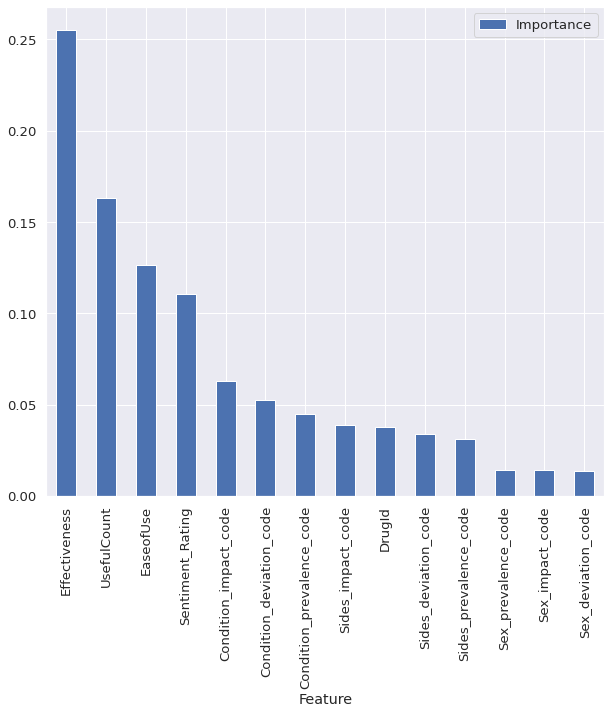

In [99]:
importances.plot.bar()

In [100]:
#xgb_cv = XGBClassifier(n_estimators=100)
score = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print(score)

from sklearn.model_selection import KFold

# Defining Features and splitting the data as train and test set
features = sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']]
target = sdss_df_fe['Satisfaction']
target.isnull().sum().sum()
features = features.fillna(features.mean())
features.isnull().sum().sum()
train_data, test_data, train_targets, test_targets = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)
num_folds=2
random_state=42
n_iter=50
kf = KFold(n_splits=num_folds, random_state=random_state)

[0.7119403  0.71293532 0.71840796 0.69900498 0.72437811 0.71691542
 0.74626866 0.70646766 0.71876556 0.71876556]
The Train set size  (20098, 14)
The Test set size  (9900, 14)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [101]:
X_train, X_test, y_train, y_test = train_test_split(dTreated.drop('Satisfaction', axis=1), dTreated['Satisfaction'],test_size=0.33)

In [104]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [105]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [106]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 77.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_,rf_random.best_score_


({'bootstrap': True,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 2000},
 0.6654391499733753)

In [107]:
y_pred = rf_random.predict(X_test)

In [108]:
RForest = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=2000)

RForest.fit(X_train, y_train)
preds = RForest.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("RandomForest's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

RandomForest's prediction accuracy WITH optimal hyperparameters is: 68.22


In [111]:
#xgb_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(RForest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.68756219 0.67562189 0.6920398  0.69054726 0.69452736 0.6761194
 0.69104478 0.70099502 0.67546043 0.69039323]
Mean: 0.6874311369979371
Standard Deviation: 0.008353721147411177


In [112]:
unique, counts = np.unique(dTreated['Satisfaction'], return_counts=True)
dict(zip(unique, counts))

{0: 8246, 1: 3022, 2: 4226, 3: 4917, 4: 9587}

In [113]:
predictions = cross_val_predict(RForest, sdss, dTreated['Satisfaction'], cv=3)
confusion_matrix(dTreated['Satisfaction'], predictions)

array([[7094,   41,  416,  200,  495],
       [1464,  233,  704,  294,  327],
       [ 868,   45, 1761,  895,  657],
       [ 342,    5,  482, 2843, 1245],
       [ 107,    3,  116,  959, 8402]])

In [114]:
print("Precision:", precision_score(dTreated['Satisfaction'], predictions, average='micro'))
print("Recall:",recall_score(dTreated['Satisfaction'], predictions, average='micro'))

Precision: 0.6778118541236082
Recall: 0.6778118541236082


In [115]:
print("F1-Score:", f1_score(dTreated['Satisfaction'], predictions, average='micro'))

F1-Score: 0.6778118541236082


In [117]:
# Classification report
import sklearn.metrics as metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(dTreated['Satisfaction'], predictions))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      8246
           1       0.71      0.08      0.14      3022
           2       0.51      0.42      0.46      4226
           3       0.55      0.58      0.56      4917
           4       0.76      0.88      0.81      9587

    accuracy                           0.68     29998
   macro avg       0.65      0.56      0.55     29998
weighted avg       0.67      0.68      0.65     29998



In [167]:

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_test)
y_test1 = lb.transform(y_test)
y_pred1= lb.transform(y_pred)
roc_auc_score(y_test1, y_pred1, average="macro")

0.7928475810556648

In [168]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score


statis=dTreated['Satisfaction']
y = label_binarize(statis, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




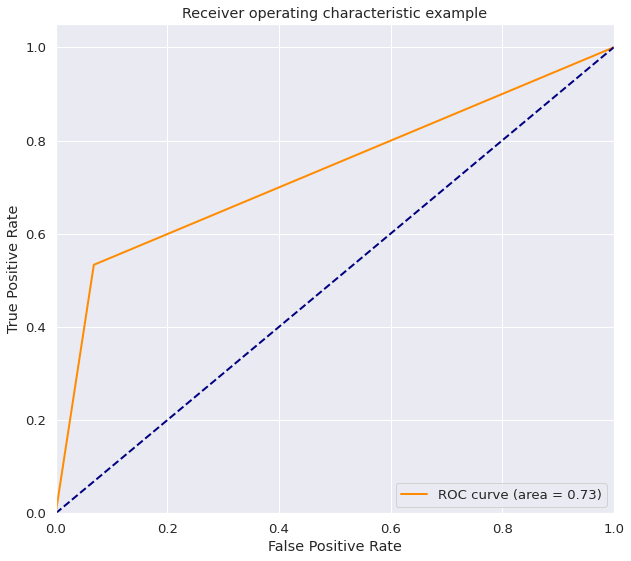

In [169]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

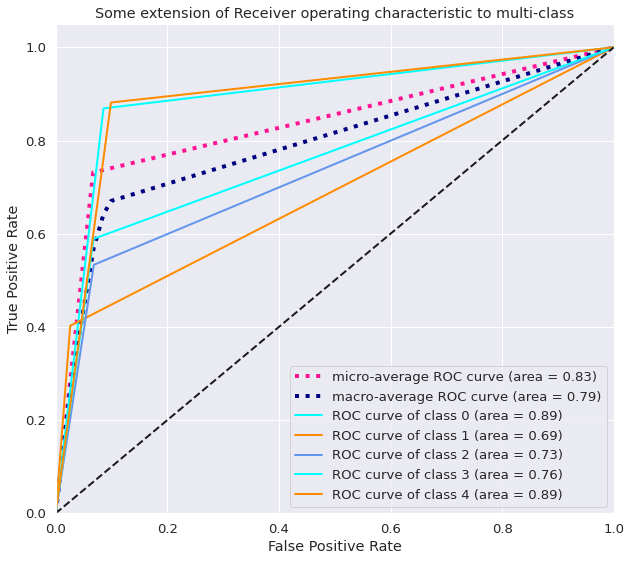

In [170]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()